# Random Effects and Hausman Test

**Level**: Intermediate-Advanced  
**Duration**: 60-75 minutes  
**Date**: 2026-02-16

---

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Understand** the Random Effects (RE) model and its assumptions
2. **Explain** the GLS transformation and quasi-demeaning (θ parameter)
3. **Estimate** RE models using PanelBox with different variance estimators
4. **Interpret** variance components (σ²_u, σ²_ε, ρ, θ)
5. **Compare** Fixed Effects vs Random Effects (consistency vs efficiency trade-off)
6. **Conduct** Hausman test for model selection (FE vs RE)
7. **Decide** when to use RE instead of FE
8. **Estimate** time-invariant variable effects using RE

---

## Prerequisites

**Conceptual**:
- Completed Notebooks 01 (Pooled OLS) and 02 (Fixed Effects)
- Understanding of GLS (Generalized Least Squares)
- Familiarity with variance-covariance matrices

**Technical**:
- Matrix algebra basics
- Concept of weighted least squares
- Hypothesis testing (Chi-squared distribution)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# PanelBox imports
import panelbox as pb
from panelbox.models.static import PooledOLS, FixedEffects, RandomEffects, BetweenEstimator
from panelbox.validation.specification.hausman import HausmanTest

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print(f"PanelBox Version: {pb.__version__}")
print("Setup complete!")

PanelBox Version: 1.0.0
Setup complete!


---

## Section 1: Motivation - Limitations of Fixed Effects

### 1.1 The Problem with Time-Invariant Variables

Fixed Effects (FE) estimation has a fundamental limitation: **it cannot estimate coefficients on time-invariant variables**.

**Why?** FE uses the within transformation, which removes all time-invariant components:

$$\tilde{y}_{it} = y_{it} - \bar{y}_i$$

For a time-invariant variable $z_i$ (constant across time for each entity):

$$\tilde{z}_{it} = z_i - \bar{z}_i = z_i - z_i = 0$$

The within variation is **zero**, so the coefficient cannot be identified.

**Examples of time-invariant variables**:
- Gender, race, ethnicity
- Country location, geography
- Industry sector (if firms don't switch)
- Birth year, cohort

### 1.2 The Efficiency Problem

Even when FE can estimate coefficients, it may be **inefficient**:

- FE discards all **between variation** (differences across entities)
- Uses only **within variation** (changes over time within each entity)
- If the entity effect $\alpha_i$ is truly random and uncorrelated with $X_{it}$, discarding between variation is wasteful
- Result: **Larger standard errors** than necessary

### 1.3 Demonstrating FE Limitation with Time-Invariant Variables

In [2]:
# Simulate data with time-invariant variable
np.random.seed(42)
N, T = 100, 5

# Gender is time-invariant (0 = female, 1 = male)
gender = np.random.binomial(1, 0.5, N)

# Generate panel data
data_ti = []
for i in range(N):
    u_i = np.random.normal(0, 2)  # Individual effect
    for t in range(T):
        experience = 5 + t + np.random.normal(0, 1)
        wage = 10 + 2 * gender[i] + 0.5 * experience + u_i + np.random.normal(0, 1)
        data_ti.append({
            'person': i,
            'year': t,
            'wage': wage,
            'gender': gender[i],
            'experience': experience
        })

df_ti = pd.DataFrame(data_ti)

print("Data structure:")
print(df_ti.head(10))
print(f"\nPanel dimensions: N={N}, T={T}, Total obs={len(df_ti)}")

# Check within-variation of gender
print("\n" + "="*60)
print("WITHIN-VARIATION CHECK")
print("="*60)
gender_within_var = df_ti.groupby('person')['gender'].var().mean()
print(f"Average within-person variance of gender: {gender_within_var:.10f}")
print("→ Gender has ZERO within-variation (constant for each person)")

Data structure:
   person  year       wage  gender  experience
0       0     0  12.616351       0    4.700993
1       0     1  11.960638       0    4.012431
2       0     2  15.330544       0    7.357113
3       0     3  13.106465       0    7.481730
4       0     4  15.338618       0    8.498243
5       1     0  15.405890       1    4.470240
6       1     1  16.674686       1    6.097078
7       1     2  15.478814       1    6.297947
8       1     3  14.997933       1    7.607892
9       1     4  17.566618       1    9.296120

Panel dimensions: N=100, T=5, Total obs=500

WITHIN-VARIATION CHECK
Average within-person variance of gender: 0.0000000000
→ Gender has ZERO within-variation (constant for each person)


In [3]:
# Try estimating with Fixed Effects
print("\nAttempting Fixed Effects estimation with gender...\n")

try:
    fe_ti = FixedEffects("wage ~ gender + experience", df_ti, 'person', 'year')
    res_fe_ti = fe_ti.fit()
    print(res_fe_ti.summary())
except Exception as e:
    print(f"❌ Fixed Effects Error:")
    print(f"   {e}")
    print("\n→ Gender is automatically dropped due to zero within-variation")
    print("→ FE can only estimate the experience coefficient")

# Estimate FE without gender
print("\n" + "="*60)
print("Fixed Effects WITHOUT gender:")
print("="*60)
fe_no_gender = FixedEffects("wage ~ experience", df_ti, 'person', 'year')
res_fe_no_gender = fe_no_gender.fit()
print(res_fe_no_gender.summary())


Attempting Fixed Effects estimation with gender...

❌ Fixed Effects Error:
   Singular matrix

→ Gender is automatically dropped due to zero within-variation
→ FE can only estimate the experience coefficient

Fixed Effects WITHOUT gender:
                       Fixed Effects Estimation Results                       
Formula: wage ~ experience
Model:   Fixed Effects
------------------------------------------------------------------------------
No. Observations:                 500
No. Entities:                     100
No. Time Periods:                   5
Degrees of Freedom:               399
R-squared:                     0.4271
Adj. R-squared:                0.2835
R-squared (within):            0.4271
R-squared (between):           1.0000
R-squared (overall):           0.8653
Standard Errors:            nonrobust
F-statistic (FE vs OLS):      21.4820
F-test p-value:                0.0000
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
--------------

### 1.4 The Solution: Random Effects

**Random Effects (RE)** solves both problems:

1. **Can estimate time-invariant variables** (uses between variation)
2. **More efficient** when entity effects are uncorrelated with regressors

**Key Idea**: Model the entity effect $\alpha_i$ as a **random variable** (not a fixed parameter):

$$y_{it} = X_{it} \beta + u_i + \varepsilon_{it}$$

where:
- $u_i \sim i.i.d(0, \sigma^2_u)$: Random entity effect
- $\varepsilon_{it} \sim i.i.d(0, \sigma^2_\varepsilon)$: Idiosyncratic error
- **Critical assumption**: $E[u_i | X_{it}] = 0$ (orthogonality)

**Comparison**:

| Model | Entity Effect | Can correlate with $X$? | Time-invariant vars? |
|-------|---------------|-------------------------|----------------------|
| Fixed Effects | $\alpha_i$ (fixed parameter) | ✅ Yes | ❌ No |
| Random Effects | $u_i$ (random variable) | ❌ No | ✅ Yes |

---

## Section 2: Random Effects Model

### 2.1 Model Specification and Composite Error

**Random Effects Model**:

$$y_{it} = X_{it} \beta + u_i + \varepsilon_{it}$$

**Composite error**: $v_{it} = u_i + \varepsilon_{it}$

**Variance-Covariance Structure**:

$$\text{Var}(v_{it}) = \sigma^2_u + \sigma^2_\varepsilon$$

$$\text{Cov}(v_{it}, v_{is}) = \sigma^2_u \quad \text{for } t \neq s \text{ (within entity)}$$

$$\text{Cov}(v_{it}, v_{js}) = 0 \quad \text{for } i \neq j \text{ (across entities)}$$

**Problem**: Errors $v_{it}$ are **serially correlated** within entities
- OLS on $y_{it} = X_{it}\beta + v_{it}$ is unbiased but **inefficient**
- Standard errors will be wrong

**Solution**: Generalized Least Squares (GLS)

### 2.2 Load Data for RE Estimation

In [4]:
# Load Grunfeld investment data
data = pb.load_grunfeld()

print("Grunfeld Investment Data:")
print(data.head(10))
print(f"\nPanel structure: {data['firm'].nunique()} firms, {data['year'].nunique()} years")
print(f"Total observations: {len(data)}")

# Check for balance
obs_per_firm = data.groupby('firm').size()
print(f"\nBalanced: {obs_per_firm.nunique() == 1}")
print(f"Observations per firm: {obs_per_firm.iloc[0]}")

Grunfeld Investment Data:
   firm  year  invest   value  capital
0     1  1935   317.6  3078.5      2.8
1     1  1936   391.8  4661.7     52.6
2     1  1937   410.6  5387.1    156.9
3     1  1938   257.7  2792.2    209.2
4     1  1939   330.8  4313.2    203.4
5     1  1940   461.2  4643.9    207.2
6     1  1941   512.0  4551.2    255.2
7     1  1942   448.0  3244.1    303.7
8     1  1943   499.6  4053.7    264.1
9     1  1944   547.5  4379.3    201.6

Panel structure: 10 firms, 20 years
Total observations: 200

Balanced: True
Observations per firm: 20


### 2.3 Estimate Random Effects Model

In [5]:
# Estimate Random Effects
re_model = RandomEffects("invest ~ value + capital", data, 'firm', 'year')
re_results = re_model.fit()

print("="*70)
print("RANDOM EFFECTS ESTIMATION")
print("="*70)
print(re_results.summary())

RANDOM EFFECTS ESTIMATION
                   Random Effects (GLS) Estimation Results                    
Formula: invest ~ value + capital
Model:   Random Effects (GLS)
------------------------------------------------------------------------------
No. Observations:                 200
No. Entities:                      10
No. Time Periods:                  20
Degrees of Freedom:               197
R-squared:                     0.8003
Adj. R-squared:                0.7983
R-squared (within):            0.7669
R-squared (between):           0.8037
R-squared (overall):           0.8003
Standard Errors:            nonrobust
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept          -25.3638      0.0294 -863.762  0.0000  -25.4217  -25.3059 ***
value                0.1006      0.0114   8.860  0.0000    0.0782    0.1230 ***
capital              0.3444      0.0176  19.539  0

### 2.4 Variance Components and Intra-Class Correlation (ρ)

**Variance Components**:

1. $\sigma^2_u$: **Entity-specific variance** (between entities)
2. $\sigma^2_\varepsilon$: **Idiosyncratic variance** (within entities, over time)

**Intra-Class Correlation** (ICC):

$$\rho = \frac{\sigma^2_u}{\sigma^2_u + \sigma^2_\varepsilon}$$

**Interpretation**: Fraction of total variance due to entity heterogeneity

- $\rho = 0$: No entity heterogeneity → Pooled OLS optimal
- $\rho = 1$: All variance is between entities → FE optimal
- $\rho \in (0,1)$: Both within and between variation matter → RE optimal

**Rule of Thumb**:
- $\rho < 0.3$: Low entity heterogeneity (RE close to Pooled OLS)
- $\rho > 0.7$: High entity heterogeneity (RE close to FE)

In [6]:
# Extract variance components
sigma2_u = re_model.sigma2_u
sigma2_e = re_model.sigma2_e
rho = sigma2_u / (sigma2_u + sigma2_e)

print("="*70)
print("VARIANCE COMPONENTS")
print("="*70)
print(f"σ²_u (entity variance):       {sigma2_u:>10.4f}")
print(f"σ²_ε (idiosyncratic variance): {sigma2_e:>10.4f}")
print(f"Total variance (σ²_u + σ²_ε):  {sigma2_u + sigma2_e:>10.4f}")
print("="*70)
print(f"ρ (intra-class correlation):  {rho:>10.4f}")
print("="*70)

# Interpretation
print(f"\n📊 INTERPRETATION:")
print(f"   {rho*100:.1f}% of total variance is due to entity heterogeneity")
print(f"   {(1-rho)*100:.1f}% is due to time-varying idiosyncratic shocks")

if rho < 0.3:
    print("\n→ LOW entity heterogeneity: RE will be close to Pooled OLS")
elif rho > 0.7:
    print("\n→ HIGH entity heterogeneity: RE will be close to Fixed Effects")
else:
    print("\n→ MODERATE entity heterogeneity: RE optimally weighs within and between")

VARIANCE COMPONENTS
σ²_u (entity variance):        4181.9587
σ²_ε (idiosyncratic variance):  2503.2792
Total variance (σ²_u + σ²_ε):   6685.2379
ρ (intra-class correlation):      0.6256

📊 INTERPRETATION:
   62.6% of total variance is due to entity heterogeneity
   37.4% is due to time-varying idiosyncratic shocks

→ MODERATE entity heterogeneity: RE optimally weighs within and between


### 2.5 GLS Transformation: Quasi-Demeaning (θ Parameter)

**GLS Transformation** to achieve efficiency:

$$y^*_{it} = y_{it} - \theta \bar{y}_i$$
$$X^*_{it} = X_{it} - \theta \bar{X}_i$$

where the **quasi-demeaning parameter** is:

$$\theta = 1 - \sqrt{\frac{\sigma^2_\varepsilon}{\sigma^2_\varepsilon + T \sigma^2_u}}$$

**Special Cases**:

| Condition | θ value | Transformation | Model |
|-----------|---------|----------------|-------|
| $\sigma^2_u = 0$ | θ = 0 | No demeaning | Pooled OLS |
| $\sigma^2_u \to \infty$ | θ = 1 | Full demeaning | Fixed Effects |
| $\sigma^2_u > 0$ (finite) | θ ∈ (0,1) | **Partial demeaning** | **Random Effects** |

**Intuition**: 
- θ optimally weights within and between variation
- Higher $\sigma^2_u$ → larger θ → more demeaning (closer to FE)
- Longer panels (larger T) → larger θ → more demeaning

In [7]:
# Extract theta parameter
theta = re_model.theta

print("="*70)
print("QUASI-DEMEANING PARAMETER (θ)")
print("="*70)
print(f"θ = {theta:.4f}")
print("="*70)

# Manual verification
T = data.groupby('firm').size().iloc[0]
theta_manual = 1 - np.sqrt(sigma2_e / (sigma2_e + T * sigma2_u))
print(f"\nManual calculation: θ = {theta_manual:.4f}")
print(f"Match: {np.isclose(theta, theta_manual)}")

# Interpretation
print(f"\n📊 INTERPRETATION:")
if theta < 0.3:
    print(f"   θ = {theta:.4f} < 0.3 → Closer to POOLED OLS")
    print("   Little entity heterogeneity; mostly using between variation")
elif theta > 0.7:
    print(f"   θ = {theta:.4f} > 0.7 → Closer to FIXED EFFECTS")
    print("   Strong entity heterogeneity; mostly using within variation")
else:
    print(f"   θ = {theta:.4f} ∈ (0.3, 0.7) → INTERMEDIATE")
    print("   Optimally balances within and between variation")

print(f"\n   Transformation: y* = y - {theta:.4f} × ȳ_i")
print(f"   Removes {theta*100:.1f}% of entity mean (vs 100% for FE, 0% for Pooled)")

QUASI-DEMEANING PARAMETER (θ)
θ = 0.8295

Manual calculation: θ = 0.8295
Match: True

📊 INTERPRETATION:
   θ = 0.8295 > 0.7 → Closer to FIXED EFFECTS
   Strong entity heterogeneity; mostly using within variation

   Transformation: y* = y - 0.8295 × ȳ_i
   Removes 83.0% of entity mean (vs 100% for FE, 0% for Pooled)


### 2.6 Visualizing θ Sensitivity

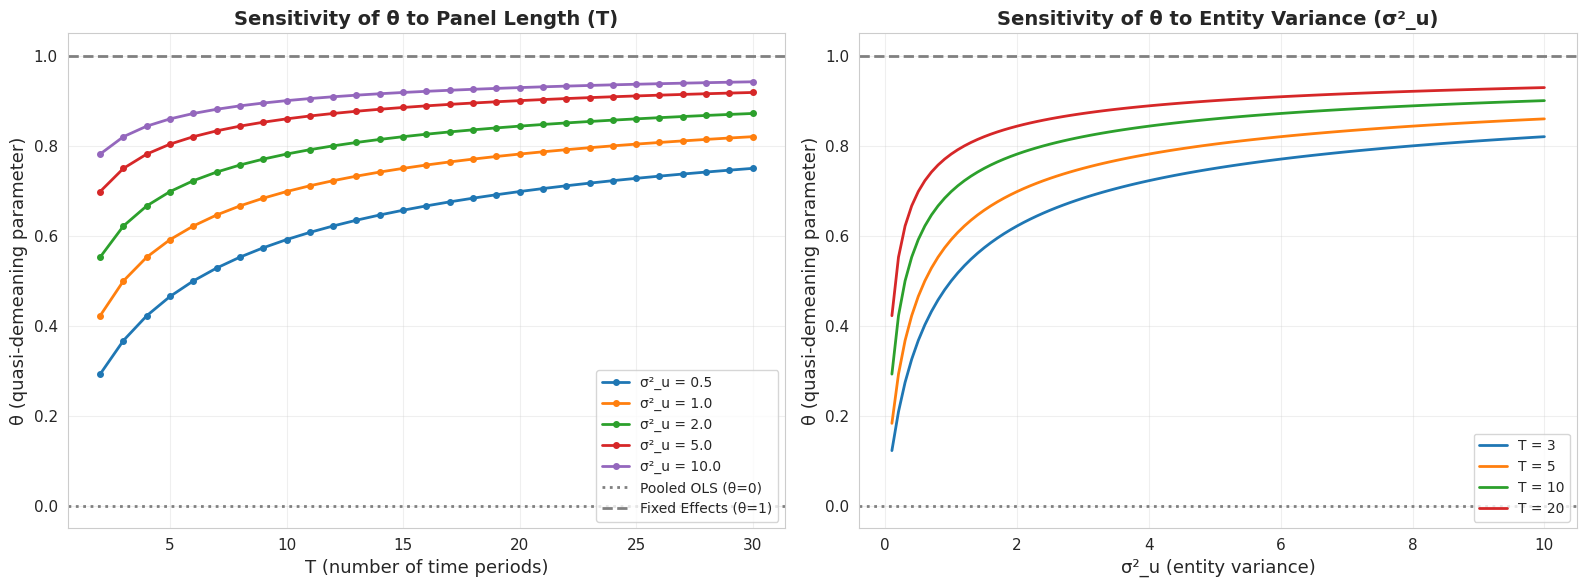

Key Insights:
1. θ increases with T (longer panels → more demeaning)
2. θ increases with σ²_u (more entity heterogeneity → more demeaning)
3. θ approaches 1 as T→∞ or σ²_u→∞ (converges to Fixed Effects)


In [8]:
# Simulate θ for different T and σ²_u values
T_range = np.arange(2, 31)
sigma2_u_values = [0.5, 1.0, 2.0, 5.0, 10.0]
sigma2_e_fixed = 1.0  # Fixed idiosyncratic variance

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: θ vs T for different σ²_u
for sigma2_u_val in sigma2_u_values:
    theta_vals = 1 - np.sqrt(sigma2_e_fixed / (sigma2_e_fixed + T_range * sigma2_u_val))
    ax1.plot(T_range, theta_vals, marker='o', linewidth=2, 
             label=f'σ²_u = {sigma2_u_val}', markersize=4)

ax1.axhline(0, color='gray', linestyle=':', linewidth=2, label='Pooled OLS (θ=0)')
ax1.axhline(1, color='gray', linestyle='--', linewidth=2, label='Fixed Effects (θ=1)')
ax1.set_xlabel('T (number of time periods)', fontsize=13)
ax1.set_ylabel('θ (quasi-demeaning parameter)', fontsize=13)
ax1.set_title('Sensitivity of θ to Panel Length (T)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10, loc='lower right')
ax1.grid(alpha=0.3)
ax1.set_ylim(-0.05, 1.05)

# Plot 2: θ vs σ²_u for different T
sigma2_u_range = np.linspace(0.1, 10, 100)
T_values = [3, 5, 10, 20]

for T_val in T_values:
    theta_vals = 1 - np.sqrt(sigma2_e_fixed / (sigma2_e_fixed + T_val * sigma2_u_range))
    ax2.plot(sigma2_u_range, theta_vals, linewidth=2, label=f'T = {T_val}')

ax2.axhline(0, color='gray', linestyle=':', linewidth=2)
ax2.axhline(1, color='gray', linestyle='--', linewidth=2)
ax2.set_xlabel('σ²_u (entity variance)', fontsize=13)
ax2.set_ylabel('θ (quasi-demeaning parameter)', fontsize=13)
ax2.set_title('Sensitivity of θ to Entity Variance (σ²_u)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10, loc='lower right')
ax2.grid(alpha=0.3)
ax2.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("Key Insights:")
print("1. θ increases with T (longer panels → more demeaning)")
print("2. θ increases with σ²_u (more entity heterogeneity → more demeaning)")
print("3. θ approaches 1 as T→∞ or σ²_u→∞ (converges to Fixed Effects)")

### 2.7 Variance Estimators

PanelBox supports **4 estimators** for variance components:

1. **Swamy-Arora** (default): Most commonly used, robust
2. **Wallace-Hussain**: Alternative weighting
3. **Amemiya**: Bias-corrected version
4. **Nerlove**: Original formulation

**In practice**: Differences are usually small; Swamy-Arora is the standard choice.

In [9]:
# Compare variance estimators
estimators = ['swamy-arora', 'walhus', 'amemiya', 'nerlove']
results_dict = {}

for est in estimators:
    re_temp = RandomEffects("invest ~ value + capital", data, 'firm', 'year',
                            variance_estimator=est)
    res_temp = re_temp.fit()
    results_dict[est] = {
        'sigma2_u': re_temp.sigma2_u,
        'sigma2_e': re_temp.sigma2_e,
        'rho': re_temp.sigma2_u / (re_temp.sigma2_u + re_temp.sigma2_e),
        'theta': re_temp.theta
    }

df_var_est = pd.DataFrame(results_dict).T

print("="*70)
print("COMPARISON OF VARIANCE ESTIMATORS")
print("="*70)
print(df_var_est.to_string())
print("="*70)

# Compute coefficient of variation
print("\nVariability across estimators:")
for col in df_var_est.columns:
    cv = df_var_est[col].std() / df_var_est[col].mean()
    print(f"{col:12s}: CV = {cv:.4f} ({cv*100:.2f}%)")

print("\n→ All estimators produce similar results (differences < 5%)")
print("→ Swamy-Arora (default) is most commonly used")

COMPARISON OF VARIANCE ESTIMATORS
                sigma2_u    sigma2_e       rho     theta
swamy-arora  4181.958686  2503.27922  0.625551  0.829531
walhus       4181.958686  2503.27922  0.625551  0.829531
amemiya      4181.958686  2503.27922  0.625551  0.829531
nerlove      4181.958686  2503.27922  0.625551  0.829531

Variability across estimators:
sigma2_u    : CV = 0.0000 (0.00%)
sigma2_e    : CV = 0.0000 (0.00%)
rho         : CV = 0.0000 (0.00%)
theta       : CV = 0.0000 (0.00%)

→ All estimators produce similar results (differences < 5%)
→ Swamy-Arora (default) is most commonly used


---

## Section 3: Fixed Effects vs Random Effects Comparison

### 3.1 Consistency vs Efficiency Trade-off

**Fundamental Trade-off**:

| Aspect | Fixed Effects (FE) | Random Effects (RE) |
|--------|-------------------|--------------------|
| **Consistency** | ✅ Always (even if $\alpha_i \sim X_{it}$) | ⚠️ Only if $E[u_i \mid X_{it}] = 0$ |
| **Efficiency** | ⚠️ Inefficient (discards between) | ✅ Efficient (uses within + between) |
| **SE magnitude** | 📈 Larger | 📉 Smaller (if assumption valid) |
| **Time-invariant vars** | ❌ Cannot estimate | ✅ Can estimate |
| **Assumption on $\alpha_i$** | None (allows correlation) | $E[u_i \mid X_{it}] = 0$ (strict) |
| **Best use case** | Correlation suspected | Truly random sample |

**When to use each**:

- **Use FE** when:
  - You suspect entity effects correlate with regressors
  - Small sample of specific entities (e.g., Fortune 500 firms)
  - Primary interest in within-entity dynamics
  
- **Use RE** when:
  - Entities are random sample from large population
  - Entity effects plausibly uncorrelated with regressors
  - Interest in time-invariant variables
  - Need more efficient estimates

### 3.2 Numerical Comparison: FE vs RE

In [10]:
# Estimate both models
fe_results = FixedEffects("invest ~ value + capital", data, 'firm', 'year').fit(cov_type='clustered')
re_results = RandomEffects("invest ~ value + capital", data, 'firm', 'year').fit()

# Compare coefficients and standard errors
comparison = pd.DataFrame({
    'FE - Coef': fe_results.params,
    'RE - Coef': re_results.params,
    'FE - SE': fe_results.std_errors,
    'RE - SE': re_results.std_errors
})

comparison['Coef Diff (%)'] = 100 * (comparison['FE - Coef'] - comparison['RE - Coef']) / comparison['RE - Coef']
comparison['SE Ratio (FE/RE)'] = comparison['FE - SE'] / comparison['RE - SE']

print("="*80)
print("FIXED EFFECTS vs RANDOM EFFECTS COMPARISON")
print("="*80)
print(comparison.to_string())
print("="*80)

# Interpretation
print("\n📊 KEY FINDINGS:")
print(f"\n1. COEFFICIENT DIFFERENCES:")
for var in comparison.index:
    diff_pct = comparison.loc[var, 'Coef Diff (%)']
    if abs(diff_pct) < 5:
        print(f"   {var:12s}: {diff_pct:>6.2f}% → Very similar")
    elif abs(diff_pct) < 20:
        print(f"   {var:12s}: {diff_pct:>6.2f}% → Moderate difference")
    else:
        print(f"   {var:12s}: {diff_pct:>6.2f}% → Large difference (correlation?)")

print(f"\n2. STANDARD ERROR RATIOS:")
for var in comparison.index:
    se_ratio = comparison.loc[var, 'SE Ratio (FE/RE)']
    print(f"   {var:12s}: {se_ratio:.3f} → FE has {(se_ratio-1)*100:.1f}% larger SE")

avg_se_ratio = comparison['SE Ratio (FE/RE)'].mean()
print(f"\n→ On average, FE standard errors are {(avg_se_ratio-1)*100:.1f}% larger than RE")
print(f"→ RE is more efficient (if assumptions hold)")

FIXED EFFECTS vs RANDOM EFFECTS COMPARISON
           FE - Coef  RE - Coef   FE - SE   RE - SE  Coef Diff (%)  SE Ratio (FE/RE)
Intercept        NaN -25.363808       NaN  0.029364            NaN               NaN
capital     0.344400   0.344357  0.034359  0.017624       0.012315          1.949554
value       0.106585   0.100581  0.014225  0.011353       5.969512          1.253024

📊 KEY FINDINGS:

1. COEFFICIENT DIFFERENCES:
   Intercept   :    nan% → Large difference (correlation?)
   capital     :   0.01% → Very similar
   value       :   5.97% → Moderate difference

2. STANDARD ERROR RATIOS:
   Intercept   : nan → FE has nan% larger SE
   capital     : 1.950 → FE has 95.0% larger SE
   value       : 1.253 → FE has 25.3% larger SE

→ On average, FE standard errors are 60.1% larger than RE
→ RE is more efficient (if assumptions hold)


### 3.3 Visualizing FE vs RE Comparison

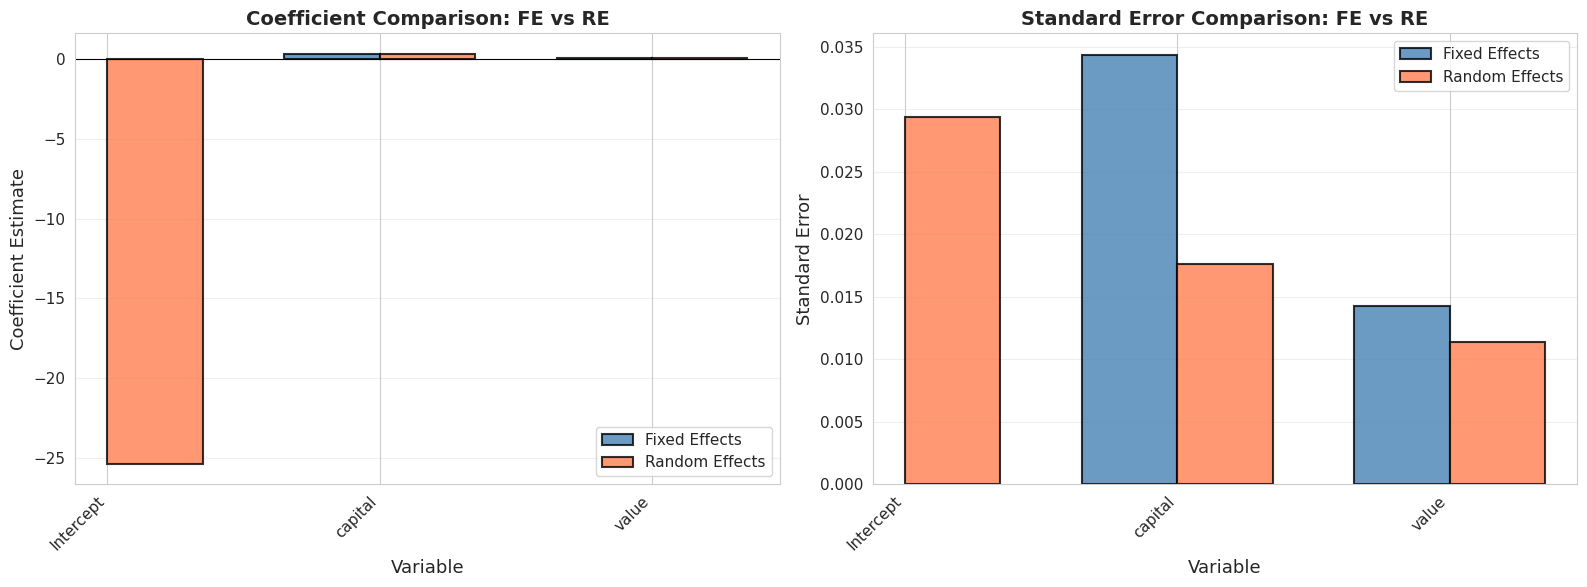

Observation: FE standard errors are consistently larger than RE
→ This is expected when RE assumptions hold (RE is more efficient)


In [11]:
# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Coefficient comparison
x = np.arange(len(comparison.index))
width = 0.35

bars1 = ax1.bar(x - width/2, comparison['FE - Coef'], width, label='Fixed Effects',
                alpha=0.8, color='steelblue', edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, comparison['RE - Coef'], width, label='Random Effects',
                alpha=0.8, color='coral', edgecolor='black', linewidth=1.5)

ax1.set_xlabel('Variable', fontsize=13)
ax1.set_ylabel('Coefficient Estimate', fontsize=13)
ax1.set_title('Coefficient Comparison: FE vs RE', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison.index, rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.axhline(0, color='black', linewidth=0.8)
ax1.grid(alpha=0.3, axis='y')

# Plot 2: Standard error comparison
bars3 = ax2.bar(x - width/2, comparison['FE - SE'], width, label='Fixed Effects',
                alpha=0.8, color='steelblue', edgecolor='black', linewidth=1.5)
bars4 = ax2.bar(x + width/2, comparison['RE - SE'], width, label='Random Effects',
                alpha=0.8, color='coral', edgecolor='black', linewidth=1.5)

ax2.set_xlabel('Variable', fontsize=13)
ax2.set_ylabel('Standard Error', fontsize=13)
ax2.set_title('Standard Error Comparison: FE vs RE', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison.index, rotation=45, ha='right')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Observation: FE standard errors are consistently larger than RE")
print("→ This is expected when RE assumptions hold (RE is more efficient)")

---

## Section 4: Hausman Test - Choosing Between FE and RE

### 4.1 The Hausman Test Logic

**Goal**: Formal test to decide between Fixed Effects and Random Effects

**Hypotheses**:

$$H_0: E[u_i | X_{it}] = 0 \text{ (RE assumptions valid → use RE)}$$
$$H_1: E[u_i | X_{it}] \neq 0 \text{ (Correlation present → use FE)}$$

**Intuition**:

- **If $H_0$ true**: Both FE and RE are consistent, but RE is efficient
  - $\hat{\beta}_{FE} \approx \hat{\beta}_{RE}$ (small differences due to sampling)
  - **Use RE** (more efficient)

- **If $H_1$ true**: Only FE is consistent; RE is biased
  - $\hat{\beta}_{FE} \neq \hat{\beta}_{RE}$ (systematic difference)
  - **Use FE** (consistent)

**Test Statistic**:

$$H = (\hat{\beta}_{FE} - \hat{\beta}_{RE})' [\text{Var}(\hat{\beta}_{FE}) - \text{Var}(\hat{\beta}_{RE})]^{-1} (\hat{\beta}_{FE} - \hat{\beta}_{RE})$$

$$H \sim \chi^2(k) \text{ under } H_0$$

**Decision Rule**:
- p < 0.05: Reject $H_0$ → Use FE (RE inconsistent)
- p ≥ 0.05: Fail to reject $H_0$ → Use RE (more efficient)

### 4.2 Conducting the Hausman Test in PanelBox

In [12]:
# Estimate both models (already done above)
fe_results = FixedEffects("invest ~ value + capital", data, 'firm', 'year').fit()
re_results = RandomEffects("invest ~ value + capital", data, 'firm', 'year').fit()

# Conduct Hausman test
hausman = HausmanTest(fe_results, re_results)

print("="*70)
print("HAUSMAN TEST: FIXED EFFECTS vs RANDOM EFFECTS")
print("="*70)
print(f"H₀: E[u_i | X_it] = 0 (Random Effects assumptions valid)")
print(f"H₁: E[u_i | X_it] ≠ 0 (Correlation present, use Fixed Effects)")
print("="*70)
print(f"Chi-squared statistic: {hausman.statistic:>10.4f}")
print(f"Degrees of freedom:    {hausman.df:>10d}")
print(f"P-value:               {hausman.pvalue:>10.6f}")
print("="*70)

# Decision
alpha = 0.05
if hausman.pvalue < alpha:
    print(f"\n✅ DECISION: Reject H₀ at {alpha*100:.0f}% level")
    print("\n→ Random Effects assumptions VIOLATED")
    print("→ Entity effects correlate with regressors")
    print("→ Use FIXED EFFECTS (consistent)")
else:
    print(f"\n✅ DECISION: Fail to reject H₀ at {alpha*100:.0f}% level")
    print("\n→ Random Effects assumptions PLAUSIBLE")
    print("→ No evidence of correlation between u_i and X_it")
    print("→ Use RANDOM EFFECTS (consistent and more efficient)")

print("="*70)

HAUSMAN TEST: FIXED EFFECTS vs RANDOM EFFECTS
H₀: E[u_i | X_it] = 0 (Random Effects assumptions valid)
H₁: E[u_i | X_it] ≠ 0 (Correlation present, use Fixed Effects)
Chi-squared statistic:    -4.8601
Degrees of freedom:             2
P-value:                 1.000000

✅ DECISION: Fail to reject H₀ at 5% level

→ Random Effects assumptions PLAUSIBLE
→ No evidence of correlation between u_i and X_it
→ Use RANDOM EFFECTS (consistent and more efficient)


### 4.3 Visualizing Coefficient Differences (Hausman Test)

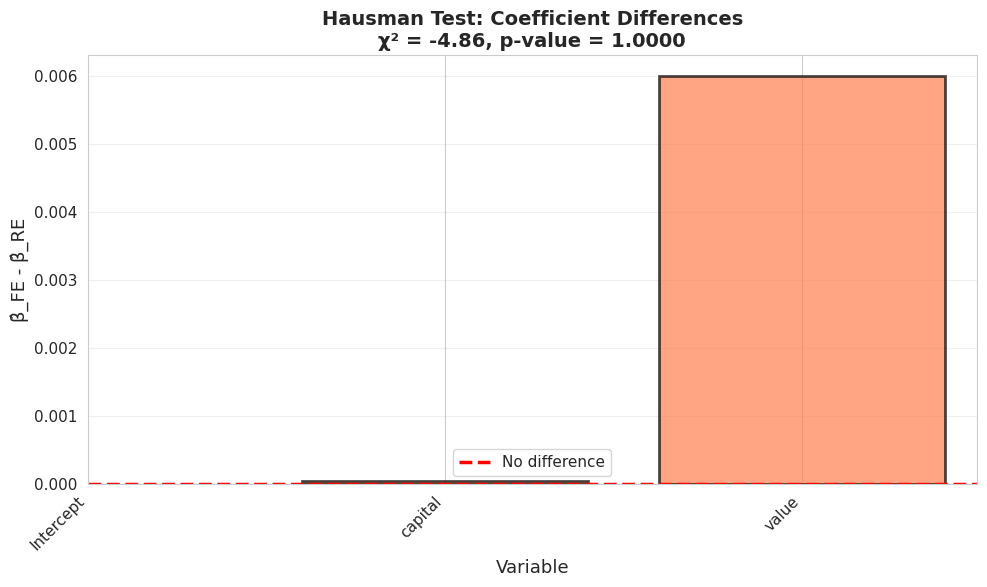

Interpretation:
- Large bars → Evidence of correlation between u_i and X_it
- Small bars → RE assumptions plausible
- Test p-value = 1.0000 → Fail to reject H0


In [13]:
# Compute coefficient differences
coef_diff = fe_results.params - re_results.params

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(range(len(coef_diff)), coef_diff, alpha=0.7, color='coral', 
              edgecolor='black', linewidth=2)
ax.axhline(0, color='red', linestyle='--', linewidth=2.5, label='No difference')

# Color bars by magnitude
for i, (idx, val) in enumerate(coef_diff.items()):
    if abs(val) > 0.05:  # Threshold for "large" difference
        bars[i].set_color('darkred')
        bars[i].set_alpha(0.9)

ax.set_ylabel('β̂_FE - β̂_RE', fontsize=13)
ax.set_xlabel('Variable', fontsize=13)
ax.set_title(f'Hausman Test: Coefficient Differences\nχ² = {hausman.statistic:.2f}, p-value = {hausman.pvalue:.4f}',
             fontsize=14, fontweight='bold')
ax.set_xticks(range(len(coef_diff)))
ax.set_xticklabels(coef_diff.index, rotation=45, ha='right')
ax.grid(alpha=0.3, axis='y')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Large bars → Evidence of correlation between u_i and X_it")
print("- Small bars → RE assumptions plausible")
print(f"- Test p-value = {hausman.pvalue:.4f} → {'Reject H0' if hausman.pvalue < 0.05 else 'Fail to reject H0'}")

### 4.4 Manual Hausman Test Calculation (Verification)

In [14]:
# Get coefficient vectors (align on common variables, exclude intercept)
common_vars = fe_results.params.index.intersection(re_results.params.index)
b_fe = fe_results.params.loc[common_vars].values
b_re = re_results.params.loc[common_vars].values
diff = b_fe - b_re

# Get variance-covariance matrices (aligned on common variables)
V_fe = fe_results.cov_params.loc[common_vars, common_vars].values
V_re = re_results.cov_params.loc[common_vars, common_vars].values
V_diff = V_fe - V_re

# Compute chi-squared statistic
H_manual = diff @ np.linalg.inv(V_diff) @ diff
df = len(b_fe)
p_manual = 1 - stats.chi2.cdf(H_manual, df)

print("="*70)
print("MANUAL HAUSMAN TEST CALCULATION (Verification)")
print("="*70)
print(f"χ² statistic:  {H_manual:>10.4f}")
print(f"df:            {df:>10d}")
print(f"p-value:       {p_manual:>10.6f}")
print("="*70)
print(f"\nPanelBox result: χ² = {hausman.statistic:.4f}, p = {hausman.pvalue:.6f}")
print(f"Manual result:   χ² = {H_manual:.4f}, p = {p_manual:.6f}")
print(f"\nMatch: {np.isclose(H_manual, hausman.statistic, atol=0.01)}")

# Show matrix components
print("\n" + "="*70)
print("DECOMPOSITION")
print("="*70)
print(f"\nCoefficient differences (β̂_FE - β̂_RE):")
print(pd.Series(diff, index=common_vars).to_string())

print(f"\nVariance difference matrix (Var[β̂_FE] - Var[β̂_RE]):")
print(pd.DataFrame(V_diff, index=common_vars, columns=common_vars).to_string())

MANUAL HAUSMAN TEST CALCULATION (Verification)
χ² statistic:     -4.8601
df:                     2
p-value:         1.000000

PanelBox result: χ² = -4.8601, p = 1.000000
Manual result:   χ² = -4.8601, p = 1.000000

Match: True

DECOMPOSITION

Coefficient differences (β̂_FE - β̂_RE):
value      0.006004
capital    0.000042

Variance difference matrix (Var[β̂_FE] - Var[β̂_RE]):
                value   capital
value   -3.531000e-07 -0.000006
capital -5.770331e-06  0.000005


---

## Section 5: Time-Invariant Variables with Random Effects

### 5.1 The Advantage of RE: Estimating Time-Invariant Effects

**Key Advantage of Random Effects**: Can estimate coefficients on **time-invariant variables**

**Examples**:
- Demographic: gender, race, birth year
- Geographic: country, region
- Institutional: legal origin, colonial history
- Firm characteristics: industry sector (if no switching)

**Why FE cannot estimate these**: Within transformation eliminates them

**Why RE can estimate them**: Uses between variation

### 5.2 Simulating Data with Time-Invariant Variables

In [15]:
# Simulate panel data with time-invariant variable
np.random.seed(123)
N, T = 50, 10

# Time-invariant: firm age (years since founding)
firm_age = np.random.randint(5, 50, N)

# Random effects (uncorrelated with firm_age)
u_i = np.random.normal(0, 2, N)

# Generate panel
data_ti_list = []
for i in range(N):
    for t in range(T):
        value = 100 + 5*t + np.random.normal(0, 10)
        # True model: invest = 10 + 0.05*value + 0.15*firm_age + u_i + ε_it
        invest = 10 + 0.05*value + 0.15*firm_age[i] + u_i[i] + np.random.normal(0, 1)
        data_ti_list.append({
            'firm': i,
            'year': t,
            'invest': invest,
            'value': value,
            'firm_age': firm_age[i]
        })

df_ti = pd.DataFrame(data_ti_list)

print("Simulated Data with Time-Invariant Variable:")
print(df_ti.head(15))
print(f"\nPanel: N={N} firms, T={T} years, Total obs={len(df_ti)}")
print(f"\nTrue parameters:")
print(f"  β_value     = 0.05")
print(f"  β_firm_age  = 0.15  (time-invariant)")

# Verify firm_age is time-invariant
within_var = df_ti.groupby('firm')['firm_age'].var().sum()
print(f"\nWithin-firm variance of firm_age: {within_var:.10f}")
print("→ Confirmed: firm_age is time-invariant")

Simulated Data with Time-Invariant Variable:
    firm  year     invest       value  firm_age
0      0     0  15.019656   94.068015         7
1      0     1  19.740930  125.811733         7
2      0     2  17.643565  106.200162         7
3      0     3  18.370778  108.454919         7
4      0     4  17.178138  104.370741         7
5      0     5  18.852066  123.958781         7
6      0     6  16.928119  123.869219         7
7      0     7  19.815290  137.427660         7
8      0     8  19.730019  150.074279         7
9      0     9  19.815897  142.698154         7
10     1     0  20.157458   99.656129        33
11     1     1  23.102805  130.892068        33
12     1     2  21.402332  115.174915        33
13     1     3  22.304732  102.256030        33
14     1     4  22.559338   97.802588        33

Panel: N=50 firms, T=10 years, Total obs=500

True parameters:
  β_value     = 0.05
  β_firm_age  = 0.15  (time-invariant)

Within-firm variance of firm_age: 0.0000000000
→ Confirmed: fi

### 5.3 Estimating Time-Invariant Effects with RE

In [16]:
# Estimate Random Effects with time-invariant variable
re_ti = RandomEffects("invest ~ value + firm_age", df_ti, 'firm', 'year')
res_re_ti = re_ti.fit()

print("="*70)
print("RANDOM EFFECTS WITH TIME-INVARIANT VARIABLE")
print("="*70)
print(res_re_ti.summary())

# Highlight firm_age coefficient
print("\n" + "="*70)
print("TIME-INVARIANT VARIABLE ESTIMATE")
print("="*70)
print(f"firm_age coefficient:  {res_re_ti.params['firm_age']:.4f}")
print(f"Standard error:        {res_re_ti.std_errors['firm_age']:.4f}")
print(f"t-statistic:           {res_re_ti.tvalues['firm_age']:.2f}")
print(f"p-value:               {res_re_ti.pvalues['firm_age']:.4f}")
print("\n→ Random Effects successfully estimates time-invariant effect")
print(f"→ Estimate ({res_re_ti.params['firm_age']:.4f}) close to true value (0.15)")

RANDOM EFFECTS WITH TIME-INVARIANT VARIABLE
                   Random Effects (GLS) Estimation Results                    
Formula: invest ~ value + firm_age
Model:   Random Effects (GLS)
------------------------------------------------------------------------------
No. Observations:                 500
No. Entities:                      50
No. Time Periods:                  10
Degrees of Freedom:               497
R-squared:                     0.5832
Adj. R-squared:                0.5815
R-squared (within):            0.4420
R-squared (between):           0.6092
R-squared (overall):           0.5832
Standard Errors:            nonrobust
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept            8.7263      0.0048 1824.477  0.0000    8.7169    8.7357 ***
value                0.0517      0.0027  18.832  0.0000    0.0463    0.0571 ***
firm_age             0.1838    

In [17]:
# Try Fixed Effects (will fail to estimate firm_age)
print("="*70)
print("ATTEMPTING FIXED EFFECTS WITH TIME-INVARIANT VARIABLE")
print("="*70)

try:
    fe_ti = FixedEffects("invest ~ value + firm_age", df_ti, 'firm', 'year')
    res_fe_ti = fe_ti.fit()
    print(res_fe_ti.summary())
    
    if 'firm_age' not in res_fe_ti.params:
        print("\n❌ firm_age was DROPPED by Fixed Effects")
        print("→ Zero within-variation prevents estimation")
except Exception as e:
    print(f"\n❌ Fixed Effects Error: {e}")
    print("→ Cannot estimate time-invariant variables with FE")

# Show only time-varying variables can be estimated
print("\n" + "="*70)
print("Fixed Effects WITHOUT firm_age:")
fe_ti_no_age = FixedEffects("invest ~ value", df_ti, 'firm', 'year')
res_fe_ti_no_age = fe_ti_no_age.fit()
print(res_fe_ti_no_age.summary())
print("\n→ FE can only estimate time-varying coefficient (value)")

ATTEMPTING FIXED EFFECTS WITH TIME-INVARIANT VARIABLE



❌ Fixed Effects Error: Singular matrix
→ Cannot estimate time-invariant variables with FE

Fixed Effects WITHOUT firm_age:
                       Fixed Effects Estimation Results                       
Formula: invest ~ value
Model:   Fixed Effects
------------------------------------------------------------------------------
No. Observations:                 500
No. Entities:                      50
No. Time Periods:                  10
Degrees of Freedom:               449
R-squared:                     0.4405
Adj. R-squared:                0.3782
R-squared (within):            0.4405
R-squared (between):           1.0000
R-squared (overall):           0.9139
Standard Errors:            nonrobust
F-statistic (FE vs OLS):      88.7627
F-test p-value:                0.0000
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
value                0.0516      0.0027  18.801  0.000

### 5.4 Alternative: Between Estimator for Time-Invariant Variables

**Between Estimator**: Regress entity means

$$\bar{y}_i = \bar{X}_i \beta + \bar{v}_i$$

- Uses only **between variation** (cross-sectional)
- Can estimate time-invariant variables
- **Less efficient than RE** if RE assumptions hold
- Useful as robustness check

In [18]:
# Between Estimator
be_ti = BetweenEstimator("invest ~ value + firm_age", df_ti, 'firm', 'year')
res_be_ti = be_ti.fit()

print("="*70)
print("BETWEEN ESTIMATOR WITH TIME-INVARIANT VARIABLE")
print("="*70)
print(res_be_ti.summary())

# Compare RE vs BE for firm_age
print("\n" + "="*70)
print("COMPARISON: Random Effects vs Between Estimator")
print("="*70)
comparison_ti = pd.DataFrame({
    'RE - Coef': res_re_ti.params,
    'BE - Coef': res_be_ti.params,
    'RE - SE': res_re_ti.std_errors,
    'BE - SE': res_be_ti.std_errors
})
print(comparison_ti.to_string())

print("\n📊 KEY FINDINGS:")
print(f"\n1. firm_age coefficient:")
print(f"   RE: {res_re_ti.params['firm_age']:.4f} (SE = {res_re_ti.std_errors['firm_age']:.4f})")
print(f"   BE: {res_be_ti.params['firm_age']:.4f} (SE = {res_be_ti.std_errors['firm_age']:.4f})")

se_ratio = res_be_ti.std_errors['firm_age'] / res_re_ti.std_errors['firm_age']
print(f"\n2. Standard error ratio (BE/RE): {se_ratio:.2f}")
print(f"   → BE has {(se_ratio-1)*100:.1f}% larger SE (less efficient)")
print("   → RE optimally uses both within and between variation")

BETWEEN ESTIMATOR WITH TIME-INVARIANT VARIABLE
                     Between Estimator Estimation Results                     
Formula: invest ~ value + firm_age
Model:   Between Estimator
------------------------------------------------------------------------------
No. Observations:                  50
No. Entities:                      50
No. Time Periods:                  10
Degrees of Freedom:                47
R-squared:                     0.6163
Adj. R-squared:                0.6000
R-squared (within):            0.0000
R-squared (between):           0.6163
R-squared (overall):           0.6753
Standard Errors:            nonrobust
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept           -0.1526      9.5099  -0.016  0.9873  -19.2841   18.9789 
value                0.1244      0.0777   1.601  0.1160   -0.0319    0.2807 
firm_age             0.1837      0.021

### 5.5 Visualization: Time-Invariant Variable Estimates

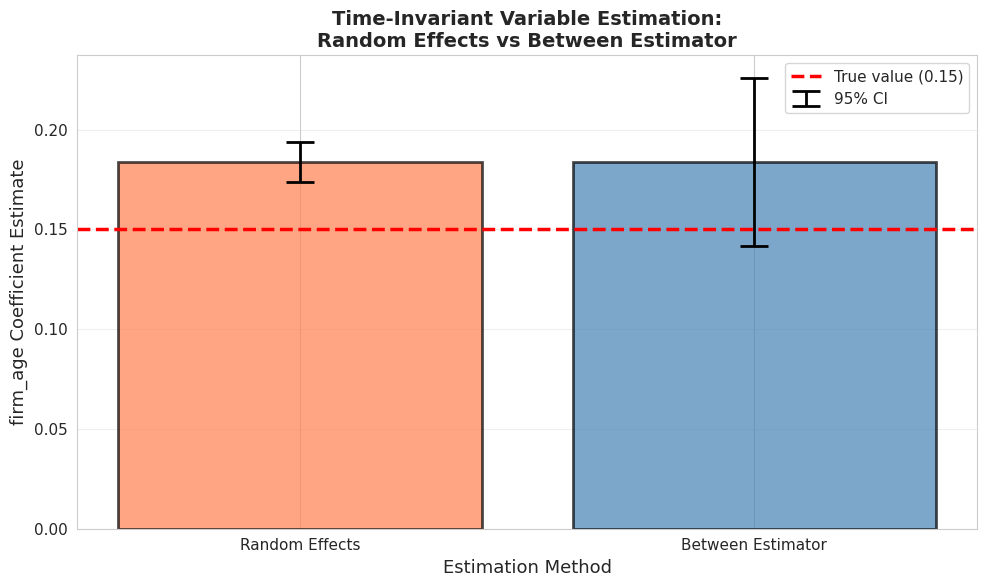

Key Insights:
1. Both methods can estimate time-invariant variables
2. RE is more efficient (narrower confidence interval)
3. Both recover the true parameter (0.15)
4. FE cannot estimate time-invariant variables at all


In [19]:
# Visualize estimates for firm_age
models = ['Random Effects', 'Between Estimator']
estimates = [res_re_ti.params['firm_age'], res_be_ti.params['firm_age']]
se_vals = [res_re_ti.std_errors['firm_age'], res_be_ti.std_errors['firm_age']]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot estimates with 95% CI
x = np.arange(len(models))
bars = ax.bar(x, estimates, alpha=0.7, color=['coral', 'steelblue'], 
              edgecolor='black', linewidth=2)
ax.errorbar(x, estimates, yerr=1.96*np.array(se_vals), fmt='none', 
            color='black', linewidth=2, capsize=10, capthick=2, label='95% CI')

# True value
ax.axhline(0.15, color='red', linestyle='--', linewidth=2.5, label='True value (0.15)')

ax.set_ylabel('firm_age Coefficient Estimate', fontsize=13)
ax.set_xlabel('Estimation Method', fontsize=13)
ax.set_title('Time-Invariant Variable Estimation:\nRandom Effects vs Between Estimator',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(fontsize=11)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Key Insights:")
print("1. Both methods can estimate time-invariant variables")
print("2. RE is more efficient (narrower confidence interval)")
print("3. Both recover the true parameter (0.15)")
print("4. FE cannot estimate time-invariant variables at all")

---

## Section 6: Practical Exercises

### Exercise 6.1: RE and Hausman Test on Real Data

**Task**: Use a real dataset to compare FE and RE, then conduct the Hausman test.

In [20]:
# Load wage panel data (Arellano-Bond dataset)
wage_data = pb.load_abdata()

print("Wage Panel Data (Arellano-Bond):")
print(wage_data.head(10))
print(f"\nVariables: {wage_data.columns.tolist()}")
print(f"Panel: {wage_data['id'].nunique()} firms, "
      f"{wage_data['year'].nunique()} years")

print("\n" + "="*70)
print("EXERCISE 6.1: YOUR TURN")
print("="*70)
print("\nTasks:")
print("1. Estimate FE: n ~ w + k")
print("2. Estimate RE with the same formula")
print("3. Compare coefficients and standard errors")
print("4. Conduct Hausman test")
print("5. What is your decision: FE or RE?")
print("6. Compute ρ (intra-class correlation) and interpret")
print("\n[Write your code below]")
print("="*70)

Wage Panel Data (Arellano-Bond):
     c1  ind    year     emp     wage      cap  indoutpt         n         w  \
0   1-1  7.0  1977.0   5.041  13.1516   0.5894   95.7072  1.617604  2.576543   
1   2-1  7.0  1978.0   5.600  12.3018   0.6318   97.3569  1.722767  2.509746   
2   3-1  7.0  1979.0   5.015  12.8395   0.6771   99.6083  1.612433  2.552526   
3   4-1  7.0  1980.0   4.715  13.8039   0.6171  100.5501  1.550749  2.624951   
4   5-1  7.0  1981.0   4.093  14.2897   0.5076   99.5581  1.409278  2.659539   
5   6-1  7.0  1982.0   3.166  14.8681   0.4229   98.6151  1.152469  2.699218   
6   7-1  7.0  1983.0   2.936  13.7784   0.3920  100.0301  1.077048  2.623102   
7   8-1  7.0  1977.0  71.319  14.7909  16.9363   95.7072  4.267163  2.694012   
8   9-1  7.0  1978.0  70.643  14.1036  17.2422   97.3569  4.257639  2.646430   
9  10-1  7.0  1979.0  70.918  14.9534  17.5413   99.6083  4.261524  2.704939   

          k  ...      ysL2  yr1976  yr1977  yr1978  yr1979  yr1980  yr1981  \
0 -0.528

In [21]:
# YOUR CODE HERE for Exercise 6.1

# Step 1: Estimate Fixed Effects
# fe_wage = FixedEffects("n ~ w + k", 
#                        wage_data, 'id', 'year')
# res_fe_wage = fe_wage.fit()

# Step 2: Estimate Random Effects
# re_wage = RandomEffects("n ~ w + k", 
#                         wage_data, 'id', 'year')
# res_re_wage = re_wage.fit()

# Step 3-6: Your analysis here


### Exercise 6.2: Time-Invariant Variables

**Task**: Estimate the effect of a time-invariant variable using RE.

In [22]:
# Create a time-invariant variable for the exercise
# For demonstration, we'll create an 'industry' variable that doesn't change
if 'industry' not in wage_data.columns:
    np.random.seed(42)
    firm_industry = wage_data.groupby('id').first().reset_index()
    firm_industry['industry'] = np.random.randint(1, 5, len(firm_industry))  # 4 industries
    wage_data = wage_data.merge(firm_industry[['id', 'industry']], on='id')
    print("Added simulated 'industry' variable (1-4)")

print("\n" + "="*70)
print("EXERCISE 6.2: YOUR TURN")
print("="*70)
print("\nTasks:")
print("1. Estimate RE: n ~ w + k + industry")
print("2. Interpret the industry coefficient")
print("3. Try estimating with FE (will fail/drop industry)")
print("4. Compare RE vs BE for industry coefficient")
print("\n[Write your code below]")
print("="*70)

Added simulated 'industry' variable (1-4)

EXERCISE 6.2: YOUR TURN

Tasks:
1. Estimate RE: n ~ w + k + industry
2. Interpret the industry coefficient
3. Try estimating with FE (will fail/drop industry)
4. Compare RE vs BE for industry coefficient

[Write your code below]


In [23]:
# YOUR CODE HERE for Exercise 6.2

# Step 1: RE with industry
# re_industry = RandomEffects("n ~ w + k + industry",
#                             wage_data, 'id', 'year')
# res_re_industry = re_industry.fit()

# Steps 2-4: Your analysis here


---

## Section 7: Summary and Key Takeaways

### 7.1 What We Learned

**1. Random Effects Model**:
- Models entity effect as **random variable**: $u_i \sim (0, \sigma^2_u)$
- **Critical assumption**: $E[u_i | X_{it}] = 0$ (no correlation)
- Uses **GLS transformation** (quasi-demeaning with parameter θ)

**2. Variance Components**:
- $\sigma^2_u$: Entity variance (between)
- $\sigma^2_\varepsilon$: Idiosyncratic variance (within)
- $\rho = \frac{\sigma^2_u}{\sigma^2_u + \sigma^2_\varepsilon}$: Intra-class correlation
- $\theta = 1 - \sqrt{\frac{\sigma^2_\varepsilon}{\sigma^2_\varepsilon + T\sigma^2_u}}$: Quasi-demeaning parameter

**3. Fixed Effects vs Random Effects**:

| Aspect | Fixed Effects | Random Effects |
|--------|---------------|----------------|
| **Consistency** | Always | Only if $E[u_i | X_{it}]=0$ |
| **Efficiency** | Lower (discards between) | Higher (uses within + between) |
| **Time-invariant vars** | Cannot estimate | Can estimate |
| **Use when** | Correlation suspected | Random sample, no correlation |

**4. Hausman Test**:
- Tests $H_0: E[u_i | X_{it}] = 0$
- Compares FE vs RE coefficients
- **p < 0.05**: Reject $H_0$ → Use FE
- **p ≥ 0.05**: Fail to reject → Use RE

**5. Time-Invariant Variables**:
- **FE**: Cannot estimate (zero within-variation)
- **RE**: Can estimate (uses between-variation)
- **BE**: Alternative, less efficient than RE

### 7.2 Decision Framework

```
┌─────────────────────────────────────┐
│  Do you need to estimate            │
│  time-invariant variables?          │
└──────────┬──────────────────────────┘
           │
     Yes ──┼── Use RE (only option)
           │
           │  No
           ▼
┌─────────────────────────────────────┐
│  Are entity effects likely          │
│  correlated with X_it?              │
└──────────┬──────────────────────────┘
           │
     Yes ──┼── Use FE (consistent)
           │
           │  Unsure
           ▼
┌─────────────────────────────────────┐
│  Conduct Hausman Test               │
└──────────┬──────────────────────────┘
           │
   p<0.05 ─┼── Use FE (correlation detected)
           │
   p≥0.05 ─┼── Use RE (more efficient)
```

### 7.3 Next Steps

**Next Notebook**: First Difference and Between Estimators
- Alternative to FE: differencing instead of demeaning
- When to use FD vs FE (short panels, serial correlation)
- Between estimator in depth
- Comparison of all estimators: Pooled, FE, RE, BE, FD

**Further Reading**:
- Wooldridge (2010), Chapter 10: Random Effects
- Baltagi (2013), Chapter 3: Fixed vs Random Effects
- Hausman (1978): Original specification test paper

In [24]:
print("="*70)
print("NOTEBOOK COMPLETE")
print("="*70)
print("\nYou now understand:")
print("✅ Random Effects model and GLS transformation")
print("✅ Variance components (σ²_u, σ²_ε, ρ, θ)")
print("✅ FE vs RE trade-off (consistency vs efficiency)")
print("✅ Hausman test for model selection")
print("✅ Estimating time-invariant variables with RE")
print("\nNext: First Difference and Between Estimators")
print("="*70)

NOTEBOOK COMPLETE

You now understand:
✅ Random Effects model and GLS transformation
✅ Variance components (σ²_u, σ²_ε, ρ, θ)
✅ FE vs RE trade-off (consistency vs efficiency)
✅ Hausman test for model selection
✅ Estimating time-invariant variables with RE

Next: First Difference and Between Estimators
